# Task 3: Comprehending the Cancellation Foundations 

The objective of this task is to establish an effective cancellation policy based on the analysis of past cancellations to help HotelFlix save 25% of the cancellations budget. Different penalty periods will be created, varying according to the number of days between the booking date and the arrival date. This strategy will allow HotelFlix to apply fairer and more precise penalties, incentivizing customers to either keep their reservations or cancel with sufficient notice. Below are the steps carried out to perform this analysis.

In [292]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the data
hotel_data = pd.read_csv('hotel_bookings.csv')

# Filling null values with zero
hotel_data.fillna(0, inplace = True)

# Handling of missing values
hotel_data.fillna({'children': 0, 'country': 'Unknown', 'agent': 0, 'company': 0}, inplace=True)

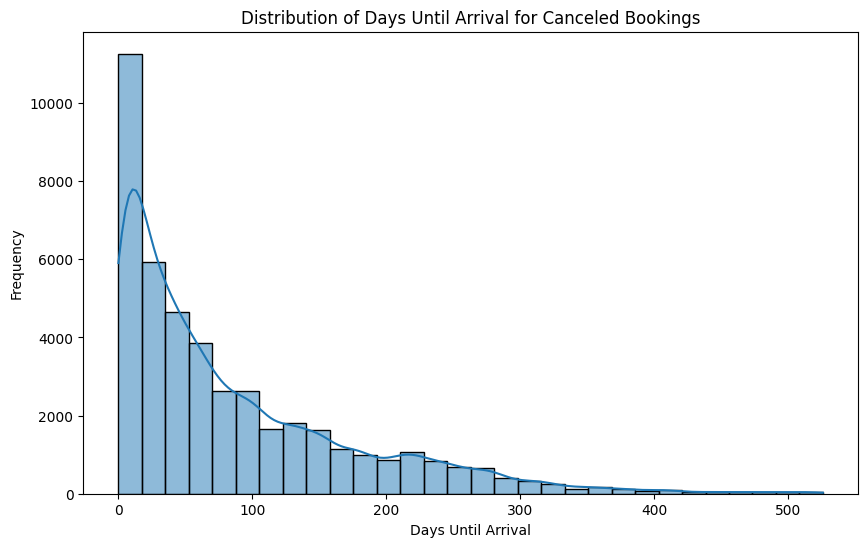

In [293]:
# Filter for canceled bookings
canceled_bookings = hotel_data[hotel_data['is_canceled'] == 1].copy()

# Map month names to numbers
months = {"January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6,
          "July": 7, "August": 8, "September": 9, "October": 10, "November": 11, "December": 12}

canceled_bookings['arrival_date_month'] = canceled_bookings['arrival_date_month'].map(months)

# Combining year, month, and day to create a datetime column for arrival_date
canceled_bookings['arrival_date'] = pd.to_datetime(canceled_bookings[['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')

# Ensure reservation_status_date is in datetime format
canceled_bookings['reservation_status_date'] = pd.to_datetime(canceled_bookings['reservation_status_date'])

# Calculate the days between the booking date and the arrival date
canceled_bookings['days_until_arrival'] = (canceled_bookings['arrival_date'] - canceled_bookings['reservation_status_date']).dt.days

# EDA: Visualization of the distribution of days until arrival for canceled bookings
plt.figure(figsize=(10, 6))
sns.histplot(canceled_bookings['days_until_arrival'], kde=True, bins=30)
plt.title('Distribution of Days Until Arrival for Canceled Bookings')
plt.xlabel('Days Until Arrival')
plt.ylabel('Frequency')
plt.show()

Feature Importances:
                          feature    weight       std
0                       lead_time  0.151922  0.017880
14                            adr  0.105561  0.006523
46        deposit_type_Non Refund  0.090699  0.094579
45        deposit_type_No Deposit  0.086285  0.094970
2       arrival_date_day_of_month  0.079152  0.002688
1        arrival_date_week_number  0.079132  0.003072
13      total_of_special_requests  0.057543  0.018725
10                          agent  0.045066  0.007509
4            stays_in_week_nights  0.045032  0.003571
8          previous_cancellations  0.037559  0.015074
3         stays_in_weekend_nights  0.027241  0.002779
12    required_car_parking_spaces  0.021829  0.005847
28       market_segment_Online TA  0.020431  0.016178
5                          adults  0.015984  0.002043
50        customer_type_Transient  0.015364  0.015395
26          market_segment_Groups  0.013733  0.022456
51  customer_type_Transient-Party  0.013267  0.012718
27   ma

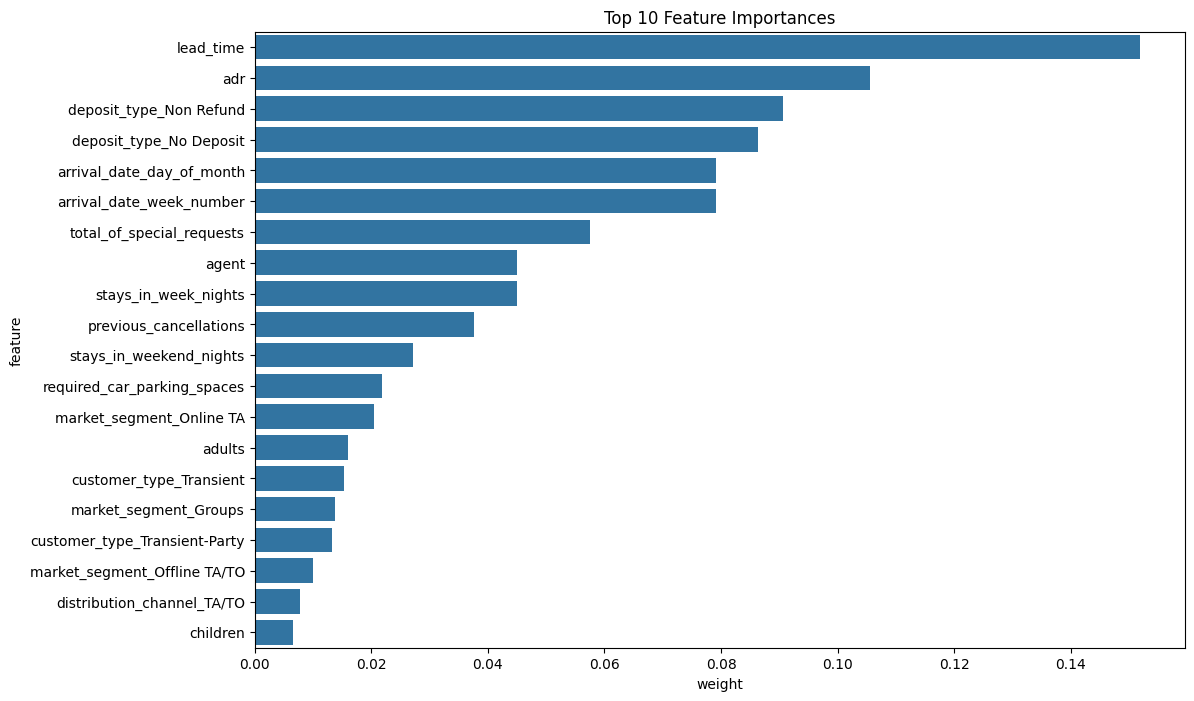

In [294]:
# Mapping features
num_features = ["lead_time", "arrival_date_week_number", "arrival_date_day_of_month", "stays_in_weekend_nights",
                "stays_in_week_nights", "adults", "children", "is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled", "agent", "company", "required_car_parking_spaces", "total_of_special_requests", "adr"]
cat_features = ["hotel", "meal", "market_segment", "distribution_channel", "reserved_room_type", "deposit_type", "customer_type"]

# Encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# Fit Random Forest to identify feature importance
X = hotel_data.drop('is_canceled', axis = 1)
y = hotel_data['is_canceled']
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])
pipeline.fit(X, y)

# Extract feature importances
importance = pipeline.named_steps['classifier'].feature_importances_
std = np.std([tree.feature_importances_ for tree in pipeline.named_steps['classifier'].estimators_], axis=0)

# Create a DataFrame for feature importances
feature_names = num_features + list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_features))
feature_importances = pd.DataFrame({'feature': feature_names, 'weight': importance, 'std': std})
feature_importances = feature_importances.sort_values(by='weight', ascending=False)

# Show the DataFrame with feature importances
print("Feature Importances:")
print(feature_importances.head(20))

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='weight', y='feature', data=feature_importances.head(20))
plt.title('Top 10 Feature Importances')
plt.show()

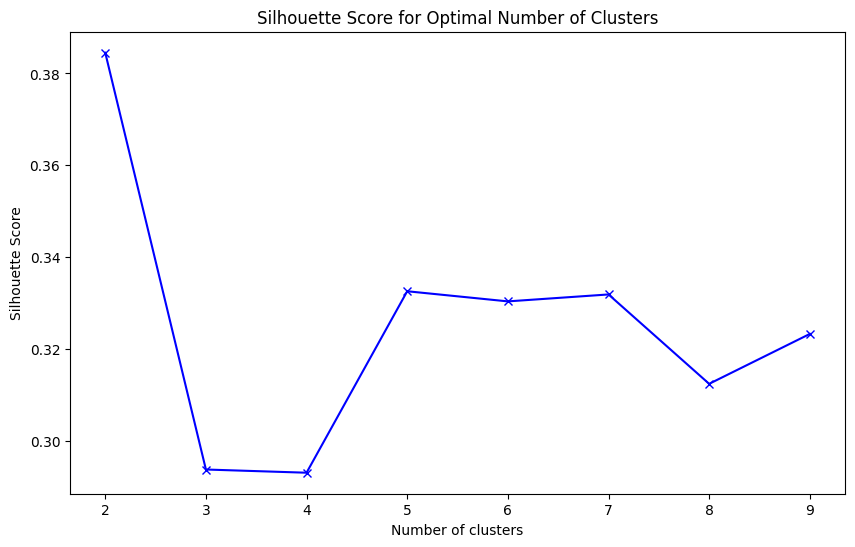

In [295]:
# Select features
features = ['lead_time', 'adr', 'deposit_type', 'days_until_arrival']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['lead_time', 'adr', 'days_until_arrival']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['deposit_type'])
    ])

# Transform the features
X = preprocessor.fit_transform(canceled_bookings[features])

# Determine optimal number of clusters
silhouette_scores = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Set n_init explicitly
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()

In [298]:
# Choose optimal number of clusters
optimal_k = 5

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)  # Set n_init explicitly
canceled_bookings.loc[:, 'cluster'] = kmeans.fit_predict(X)  # Use .loc to avoid SettingWithCopyWarning

# Cluster summary including deposit_type
cluster_summary = canceled_bookings.groupby('cluster').agg({
    'adr': 'mean', 
    'lead_time': 'mean', 
    'days_until_arrival': 'mean',
    'deposit_type': lambda x: x.value_counts().index[0]  # Most common deposit_type per cluster
}).reset_index()
cluster_summary.columns = ['Cluster', 'Average ADR', 'Average Lead Time', 'Average Days Until Arrival', 'Most Common Deposit Type']

# Display the cluster summary and penalty recommendations
print(cluster_summary)

   Cluster  Average ADR  Average Lead Time  Average Days Until Arrival  \
0        0    95.728938         118.198315                   81.570296   
1        1   183.459330          84.801102                   53.941800   
2        2    80.795684         339.151445                  277.732563   
3        3    90.468739          60.883457                   27.990159   
4        4    89.343971         254.916558                  104.761645   

  Most Common Deposit Type  
0               Non Refund  
1               No Deposit  
2               Non Refund  
3               No Deposit  
4               No Deposit  


## Group penalties for cancellations

This analysis now includes the most common deposit_type for each cluster. By examining lead_time, adr, and deposit_type, we can create a more comprehensive clustering model to better understand cancellation behaviors.

Including deposit_type provides additional insights into the nature of cancellations. By clustering the data based on these features, we can implement a more effective and fair cancellation policy. 


### Cluster 2:
- 365 - 180 Days
- Average Lead Time: 339.15 days
- Penalty: 25%
- Recommendation: Encourage early bookings with flexible cancellation policies. Offer moderate penalties to balance the risk of last-minute cancellations. Provide incentives for early bookings to retain customers.

### Clusters 4:
- 179 - 100 Days
- Average Lead Time: 254.92 days
- Penalty: 50%
- Recommendation: Offer higher penalties for this range to discourage cancellations as the booking date approaches. Provide incentives for guests to retain their bookings, such as discounts for confirming their stay or additional services.

### Clusters 0:
- 99 - 75 Days
- Average Lead Time: 118.20 days
- Penalty: 75%
- Recommendation: Implement stricter penalties as cancellations in this range are harder to replace. Communicate the importance of commitment to guests and offer small discounts for confirming the stay.

### Clusters 1:
- 74 - 30 Days
- Average Lead Time: 84.80 days
- Penalty: 90%
- Recommendation: Enforce the highest penalties to protect revenue. Provide clear communication about the policy and offer alternatives like rescheduling instead of cancellation. Consider offering additional incentives for confirming the stay within this period.

### Clusters 3:
- 29 - 7 Days
- Average Lead Time: 60.88 days
- Penalty: 100%
- Recommendation: This range should maintain strict penalties. Offer services like travel insurance through partners to cover unforeseen cancellations. Provide incentives for last-minute confirmations to fill any gaps left by cancellations.


### All clusters (due to last-minute cancellations)
- 6 - 0 Days
- Average Lead Time: Varies
- Penalty: 100%
- Recommendation: Ensure the highest penalties apply. Provide last-minute booking options to fill gaps left by cancellations and communicate availability to potential guests.

---

By implementing a tiered cancellation policy based on our detailed analysis of lead time, ADR, and deposit type, HotelFlix can significantly reduce last-minute cancellations and enhance booking stability. The tailored penalties, which increase as the booking date approaches, encourage early commitment and discourage cancellations closer to the arrival date. With clear communication and incentives for guests to confirm their stays, this strategy is projected to save HotelFlix 25% of the cancellations budget, optimizing both revenue and occupancy rates.